# Can a predictive model be built for future prediction of the possibility of complaints of the specific type that you identified in response to Question 1?

## In this exercise, you will use a feature-engineered dataset to determine whether a predictive model can be built to predict the complaint (of the Complaint Type that you decided to focus on in Week 2) by using past data.

## Using the best model, you need to predict the number of future complaints (of the Complaint Type that you decided to focus on in Question 1).

### My approach to this exercise is going to be straightforward.  My plan is to create a time series forecasting model to predict the number of total complaints in future months by training the model on the 311 data accumulated over the past years.  This model will be focused on predicting the number of heat/hot water complaints for the Bronx borough in the future months and years to come.

In [192]:
#loading libraries
import pandas as pd
import numpy as np

In [34]:
# loading 311 data set
filename = 'https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status'
df1 = pd.read_csv(filename, parse_dates=True)

Series([], Name: created_date, dtype: datetime64[ns])

In [189]:
df1.head()

,created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status
0,2019-10-15T15:41:56.000,44062706,PLUMBING,10031.0,539 WEST 152 STREET,WEST 152 STREET,ADDRESS,NEW YORK,The following complaint conditions are still o...,MANHATTAN,40.830282,-73.945859,NaN,RESIDENTIAL BUILDING,Open
1,2019-10-15T12:35:49.000,44063797,UNSANITARY CONDITION,11203.0,175 EAST 52 STREET,EAST 52 STREET,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.657065,-73.928988,NaN,RESIDENTIAL BUILDING,Open
2,2019-10-15T19:31:10.000,44061239,FLOORING/STAIRS,11434.0,114-05 170 STREET,170 STREET,ADDRESS,Jamaica,The following complaint conditions are still o...,QUEENS,40.691052,-73.779762,NaN,RESIDENTIAL BUILDING,Open
3,2019-10-15T08:48:36.000,44060423,UNSANITARY CONDITION,11212.0,1092 WILLMOHR STREET,WILLMOHR STREET,ADDRESS,BROOKLYN,The following complaint conditions are still o...,BROOKLYN,40.656896,-73.917927,NaN,RESIDENTIAL BUILDING,Open
4,2019-10-15T15:27:13.000,44061433,UNSANITARY CONDITION,10466.0,646 EAST 231 STREET,EAST 231 STREET,ADDRESS,BRONX,The following complaint conditions are still o...,BRONX,40.892594,-73.859870,NaN,RESIDENTIAL BUILDING,Open


In [70]:
df1.shape

(5874552, 15)

### I am going to focus on complaints from the Bronx

In [122]:
df = pd.DataFrame(df1, columns=['complaint_type','created_date', 'borough']) # selecting the df1 variables.
df.columns = ['complaint_type','date','borough'] # changing incident_addess variable to address to match data frame A.
df.head()

,complaint_type,date,borough
0,PLUMBING,2019-10-15T15:41:56.000,MANHATTAN
1,UNSANITARY CONDITION,2019-10-15T12:35:49.000,BROOKLYN
2,FLOORING/STAIRS,2019-10-15T19:31:10.000,QUEENS
3,UNSANITARY CONDITION,2019-10-15T08:48:36.000,BROOKLYN
4,UNSANITARY CONDITION,2019-10-15T15:27:13.000,BRONX


### Here I'm narrowing the dataset down further, focusing on the heat/hot water complaints in the Bronx.

In [123]:
myrows = ((df.complaint_type=='HEAT/HOT WATER')&(df.borough=='BRONX'))
df = df.loc[myrows,:]
df.head()

,complaint_type,date,borough
20,HEAT/HOT WATER,2019-10-15T22:13:11.000,BRONX
24,HEAT/HOT WATER,2019-10-15T22:27:15.000,BRONX
32,HEAT/HOT WATER,2019-10-15T08:25:25.000,BRONX
49,HEAT/HOT WATER,2019-10-15T11:15:59.000,BRONX
75,HEAT/HOT WATER,2019-10-15T20:41:56.000,BRONX


In [124]:
# Imports for time series and visualization
from datetime import datetime
from dateutil.parser import parse
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [125]:
df['date']= pd.to_datetime(df['date']) # Coverting the date column to datetime type.

In [126]:
df.dtypes

complaint_type            object
date              datetime64[ns]
borough                   object
dtype: object

In [127]:
df.isnull().sum() # Verifying that there are no missing values.

complaint_type    0
date              0
borough           0
dtype: int64

### According to the data, we're working with roughly five years of data from the Bronx.

In [196]:
df = df.sort_values('date')
df['date'].min(), df['date'].max()

(Timestamp('2014-03-11 00:00:00'), Timestamp('2019-10-15 23:52:26'))

### Here I'm going to convert heat/hot water into the integer 1, so we can easily sum up the number of heat/hot water complaints per month.

In [136]:
df = df.replace('HEAT/HOT WATER', 1)
df.reset_index(drop=True, inplace=True)
df.head()

,complaint_type,date,borough
0,1,2014-03-11,BRONX
1,1,2014-03-11,BRONX
2,1,2014-03-11,BRONX
3,1,2014-03-11,BRONX
4,1,2014-03-11,BRONX


In [139]:
df2 = df.groupby('date')['complaint_type'].sum().reset_index() #Grouping by date and summing up the number of complaints.
df2.head()

,date,complaint_type
0,2014-03-11,138
1,2014-03-12,153
2,2014-03-13,460
3,2014-03-14,257
4,2014-03-15,130


In [140]:
df2 = df2.set_index('date') #Setting the data frame to an index.
df2.index

DatetimeIndex(['2014-03-11 00:00:00', '2014-03-12 00:00:00',
               '2014-03-13 00:00:00', '2014-03-14 00:00:00',
               '2014-03-15 00:00:00', '2014-03-16 00:00:00',
               '2014-03-17 00:00:00', '2014-03-18 00:00:00',
               '2014-03-19 00:00:00', '2014-03-20 00:00:00',
               ...
               '2019-10-15 22:13:11', '2019-10-15 22:15:00',
               '2019-10-15 22:21:17', '2019-10-15 22:21:42',
               '2019-10-15 22:27:15', '2019-10-15 22:48:55',
               '2019-10-15 23:28:19', '2019-10-15 23:28:25',
               '2019-10-15 23:49:57', '2019-10-15 23:52:26'],
              dtype='datetime64[ns]', name='date', length=280833, freq=None)

In [142]:
y = df2['complaint_type'].resample('MS').sum() # Resampling and aggregating totals by month.
y.head()

date
2014-03-01    5177
2014-04-01    4584
2014-05-01    1313
2014-06-01     941
2014-07-01     741
Freq: MS, Name: complaint_type, dtype: int64

### You can see by the graph below, as one would expect in New York City, the heating complaints are seasonally correlated.  Logically, you have the most complaints in the middle of winter and the fewest complaints in the middle of summer.

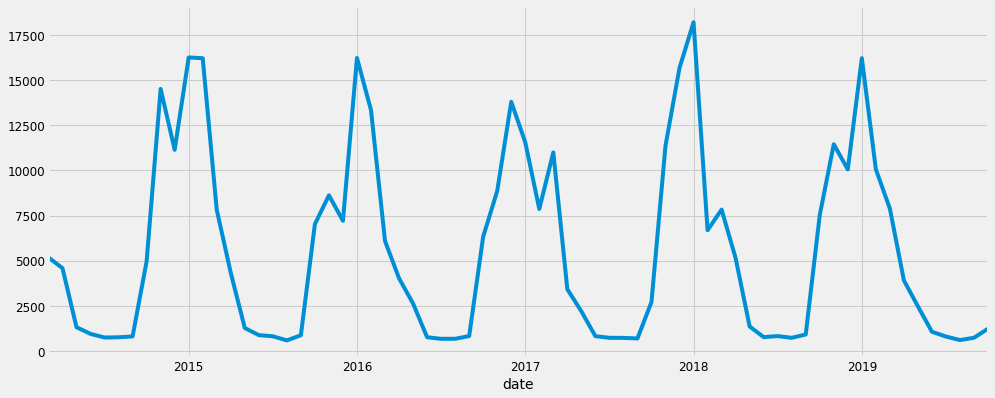

In [143]:
y.plot(figsize=(15, 6))
plt.show()

### The graphs below show us trend isn't quite stable from year to year, but there is a dinstinctly obvious seasonal pattern over time.

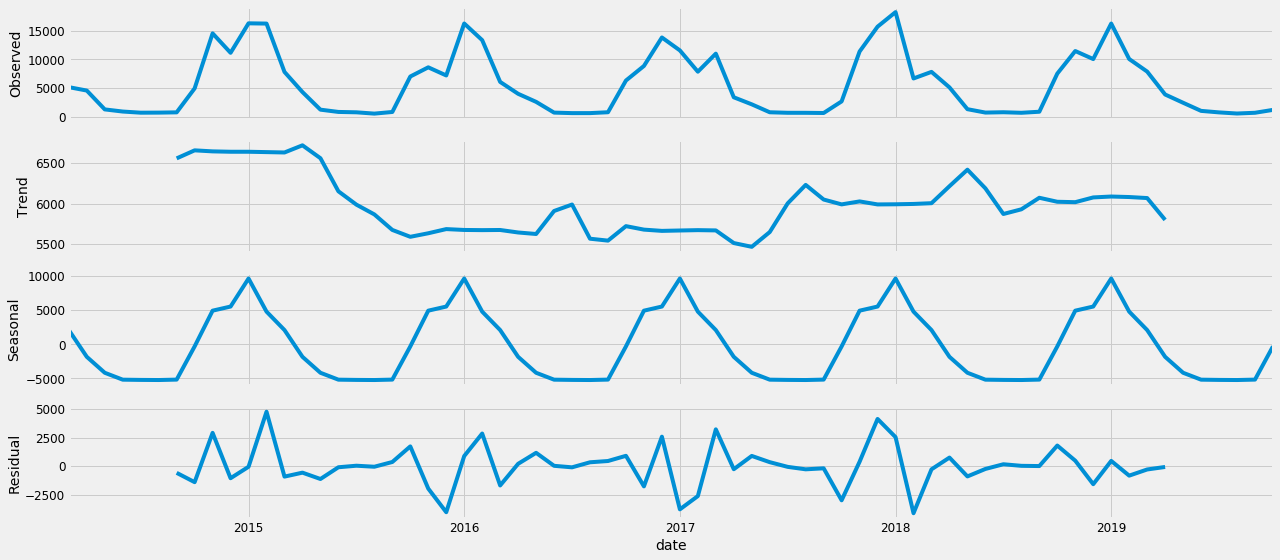

In [144]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

### Forecasting future complaints using ARIMA (Autoregressive Integrated Moving Average)

### Parameter Selection for the ARIMA Time Series Model:

In [145]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

### Looking for the lowest AIC (Akaike's Information Criterion), which will find the best optimized parameters for the algorithm.  The lowest AIC value is about  744.85.

In [177]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue          

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1390.245950227242
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1104.371331097646
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1024.7534439793706
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:791.468154071343
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1040.5604207950096
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1011.9663699265044
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:815.604539071346
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:792.2003942567079
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1319.2453156406063
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1042.1312159855506
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1008.9151485846477
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:774.451170080855
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1041.6811537652516
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:986.3543962197697
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:816.1576021535382
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:769.8505824529451
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1281.6295534584883
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1028.611004310646
ARIMA

### Here I fit the model using the parameters from the lowest AIC output to achieve best model performance.

In [178]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9882      0.171     -5.781      0.000      -1.323      -0.653
ma.S.L12      -1.5840      0.317     -4.990      0.000      -2.206      -0.962
sigma2      1.459e+06   6.53e+05      2.236      0.025     1.8e+05    2.74e+06


### The residuals appear to be nearly normally distributed.  The histogram distrubtion looks nearly normal.

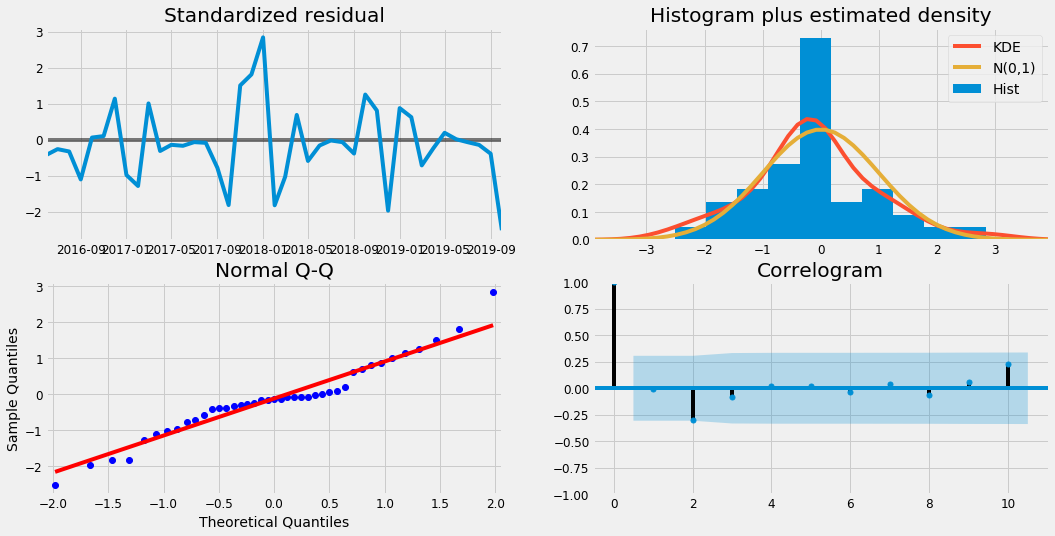

In [179]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### Now I will perform some model validation and compare the predictions for 2018-19 to the actual data.  It syncs up nicely.

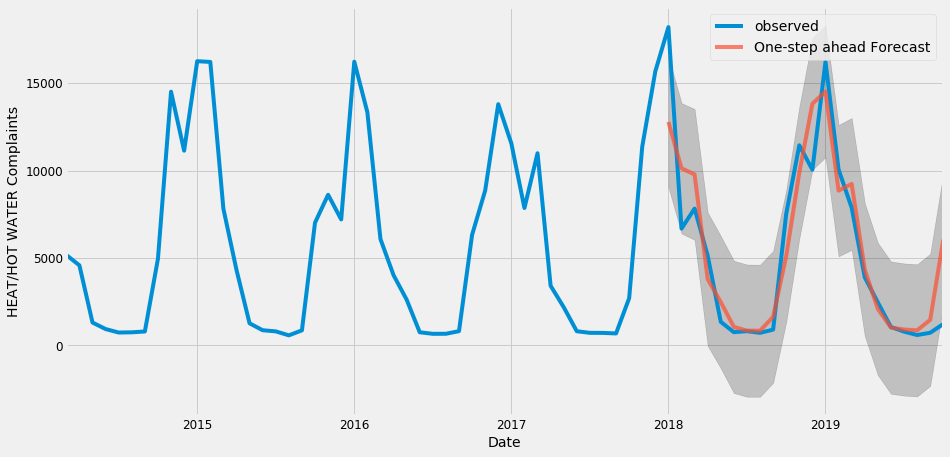

In [184]:
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('HEAT/HOT WATER Complaints')
plt.legend()

plt.show()

In [185]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 4621513.3


In [186]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2149.77


### Considering the scale of 15,000+ complaints distributed throughout each year, I think this is a workable model.

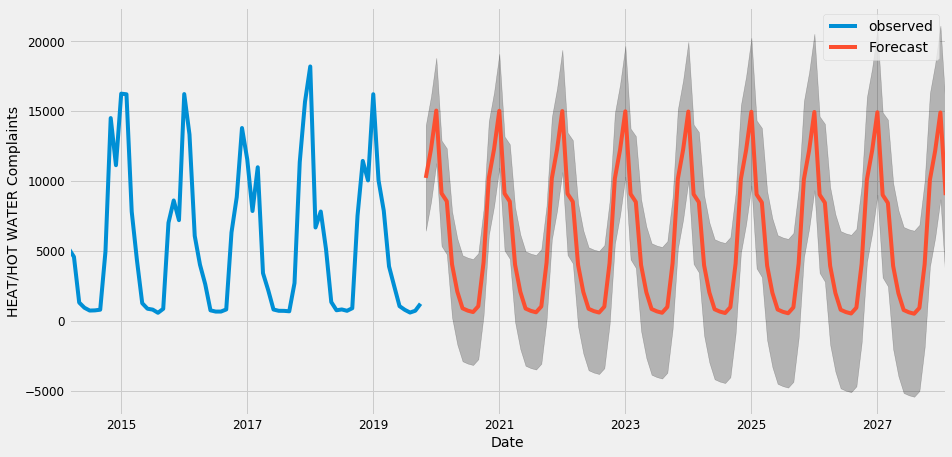

In [188]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('HEAT/HOT WATER Complaints')

plt.legend()
plt.show()

## Conclusions and Remarks

### And finally, I have plotted the complaint forecast out over the next 8 years.  The seasonal trend continues as expected, and the confidence interval widens further for each year following the data used to train the model, which should be expected.  Overall, this looks to be an accurate and valuable forecast for the number of complaints we can expect each month in the Bronx over the next several years.